## Machine learning phases of matter
https://www.nature.com/articles/nphys4035  
*Juan Carrasquilla & Roger G. Melko*  
Julia notebook uses data from https://github.com/carrasqu/data_nature_phy_paper  
As part of the Machine Learning and Quantum Matter seminar  
*Nikkin Dev, Markus Schmitt, Chae-Yeun Park, Simon Trebst*

### 1. Loading packages

In [1]:
using PyPlot
using Random, Statistics
using Flux
using BSON # To save model and weights

In [2]:
] status Flux PyPlot BSON

      Status `~/.julia/environments/v1.6/Project.toml`
  [fbb218c0] BSON v0.3.3
  [587475ba] Flux v0.12.1
  [d330b81b] PyPlot v2.9.0


### 2. Helper functions
Download dataset using the command  
**git clone https://github.com/carrasqu/data_nature_phy_paper**

In [3]:
# Loading X data
function load_x(L,train_or_test,n,tri=false)
    triangular = tri ? "/TRIANGX" : "/X" 
    file_name = "./data_nature_phy_paper/to_upload/L_"*string(L)*triangular*train_or_test*".txt"
    file = open(file_name,"r")
    train_x = zeros(Float32, L*L, n[train_or_test])
    i = 1
    for line in readlines(file)
        train_x[:,i] = map(split(line,' ')) do element parse(Float32, element) end 
        i += 1
    end
    close(file)
    return copy(train_x)
end

# Loading Y data
function load_y(L,train_or_test,n,tri=false)
    triangular = tri ? "/TRIANGy" : "/y" 
    file_name = "./data_nature_phy_paper/to_upload/L_"*string(L)*triangular*train_or_test*".txt"
    file = open(file_name,"r")
    train_y = []
    for line in readlines(file)
        push!(train_y,parse(Float64,line))
    end
    close(file)
    return copy(train_y)
end

load_y (generic function with 2 methods)

### 3. Loading training and test data

In [4]:
L = 10 # LxL lattice`
n = Dict("train" => 100000, "test" => 10250)

Dict{String, Int64} with 2 entries:
  "test"  => 10250
  "train" => 100000

In [5]:
train_x = load_x(L,"train",n)
train_y = load_y(L,"train",n)
test_x = load_x(L,"test",n)
test_y = load_y(L,"test",n);

In [6]:
println(size(train_x))
println(size(train_y))
println(size(test_x))
println(size(test_y))

(100, 100000)
(100000,)
(100, 10250)
(10250,)


## Defining a neural network model using Flux
If this is the first time running the notebook, skip part "*6. Loading model and weights*". If you want to load the saved model again to save training time, skip to part 6 and continue to analysis

### 4. Building model by chaining layers

In [7]:
function build_model(layers)
    m = Dense(layers[1], layers[2], sigmoid)
    for j in 3:length(layers)
        m = Chain(m, Dense(layers[j-1], layers[j],sigmoid))
    end
    return m
end

build_model (generic function with 1 method)

### 5. Initialize parameters and test model

In [8]:
net_layers=[L*L,100,2] # 100 in hidden layer and 2 in output layer
 
neural_network = build_model(net_layers) # Create model
params = Flux.params(neural_network) # Initialize params

neural_network(reshape(train_x[:,1],100)) # Output vector

2-element Vector{Float32}:
 0.474466
 0.7358876

### 6. Loading model and weights

In [7]:
using Zygote
# https://stackoverflow.com/questions/66395998/saving-and-loading-model-and-the-best-weight-after-training-in-sciml-julia

In [8]:
] status Zygote

      Status `~/.julia/environments/v1.6/Project.toml`
  [e88e6eb3] Zygote v0.6.10


In [9]:
# Note: Model and weights name should be the same as the ones saved
# Use BSON.parse(<model or weight file>) to find its name
BSON.@load "./models_and_weights/"*string(L)*"_model.bson" neural_network
BSON.@load "./models_and_weights/"*string(L)*"_params.bson" params
Flux.loadparams!(neural_network, params)

### 7. Defining cost function

In [10]:
function cost_function(predictions, labels)
    """This function evaluates the cost function for given predictions and labels
    Args:
    * predictions: Predictions from neural net. Array of shape mathcal T x 10.
    * labels: Correct labels for the corresponding images. Array of mathcal T integers.
    Returns: Cost associated with the neural network predictions for the given data.
    """

    labels = Flux.onehotbatch(labels, 0:1)

    cost = sum((predictions-labels).^2)
    return cost / size(labels)[2]
end

cost_function (generic function with 1 method)

With this, we can check the performance of our randomly initialized network in classifying some of our images:

### 8. Creating batches of data

In [11]:
batch = train_x[:,1:128]    # select a batch of images
labels = train_y[1:128] # and corresponding labels

# ! compute neural network predictions
predictions = neural_network(reshape(batch, L*L,size(batch)[2]))

# ! evaluate the cost function
cost_function(predictions,labels)

0.026474154f0

Now, what is missing is a function to compute the gradients of the cost function. This is easily solved using `Flux.gradient()` for automatic differentiation:

### 9. Cost function gradient for back propagation

In [12]:
function cost_function_gradient(net, params, batch, labels, L)
    return Flux.gradient(() -> cost_function(net(reshape(batch, L*L,size(batch)[2])),labels), params) 
end

cost_function_gradient (generic function with 1 method)

Finally, we are ready to train the network:

### 10. Running epochs

In [15]:
function evaluate_predictions(predictions, labels)
    """This is a helper function that counts how many of the given predictions match the labels.
    Args:
    * `predictions`: Predictions from neural network (=activations on output layer)
    * `labels`: correct labels
    Returns: Number of correct predictions, i.e., number of cases, in which the index of the maximal 
    activation matches the given label.
    """
    pred_labels = [Int(findmax(predictions[:,i])[2])-1 for i in 1:size(predictions)[2]]
        
    return sum(pred_labels .== labels)
end


prng_key = Random.seed!(1234)

# Here we define the hyperparamters
num_epochs = 100 # Number of epochs to loop over
learning_rate = 0.001 # Learning rate
batch_size = 128 # Size of mini-batches

# Compute the number of mini-batches that matches the chosen mini-batch size
batch_number = floor(Int,size(train_x)[end] / batch_size)

# Evaluate network and assess performance
predictions = neural_network(reshape(test_x,L*L,size(test_x)[2]))

current_cost = cost_function(predictions, test_y)
correct_predictions = evaluate_predictions(predictions, test_y)
println("Initial cost: $(current_cost)")
println("Correctly predicted labels: $(correct_predictions) / $(length(test_y))")
sleep(1)

for n in 1:num_epochs
    IJulia.clear_output(true)
    println("Epoch $(n)")
    order = shuffle(1:length(train_y))
    labels = reshape(train_y[order][1:Int(batch_number*batch_size)], 128,:)
    samples = reshape(train_x[:,order][:,1:Int(batch_number*batch_size)], L*L,128,:)
    
    


    for i in 1:batch_number

        # Compute gradients
        gs=cost_function_gradient(neural_network, params, samples[:,:,i], labels[:,i],L)
        
        # Perform SGD parameter update step
        for p in params
            Flux.Optimise.update!(p,learning_rate*gs[p]) # Remove minus sign for learning rate in latest versions
        end
        
    end

    # Evaluate network and assess performance
    predictions = neural_network(reshape(test_x,L*L,size(test_x)[2]))
    current_cost = cost_function(predictions, test_y)    
    correct_predictions = evaluate_predictions(predictions, test_y)
    println("Current cost: $(current_cost)")
    println("Correctly predicted labels: $(correct_predictions)/$(length(test_y))")

end

Epoch 100
Current cost: 0.10848266
Correctly predicted labels: 9549/10250


### 6. Saving model and weights

In [16]:
BSON.@save "./models_and_weights/"*string(L)*"_model.bson" neural_network # Save model
params = Flux.params(neural_network)
BSON.@save "./models_and_weights/"*string(L)*"_params.bson" params # Save weights

### Analysis

In [13]:
# Data from https://github.com/carrasqu/data_nature_phy_paper
T_train = [1.0000000000000000 1.0634592657106510 1.1269185314213019 1.1903777971319529 1.2538370628426039 1.3172963285532548 1.3807555942639058 1.4442148599745568 1.5076741256852078 1.5711333913958587 1.6345926571065097 1.6980519228171607 1.7615111885278116 1.8249704542384626 1.8884297199491136 1.9518889856597645 2.0153482513704155 2.0788075170810667 2.1422667827917179 2.2057260485023691 2.2691853142130203 2.3326445799236715 2.3961038456343227 2.4595631113449739 2.5230223770556250 2.5864816427662762 2.6499409084769274 2.7134001741875786 2.7768594398982298 2.8403187056088810 2.9037779713195322 2.9672372370301834 3.0306965027408346 3.0941557684514858 3.1576150341621370 3.2210742998727881 3.2845335655834393 3.3479928312940905 3.4114520970047417 3.4749113627153929 3.5383706284260401]
T_test = [1.0000000000000000 1.0634592657106510 1.1269185314213019 1.1903777971319529 1.2538370628426039 1.3172963285532548 1.3807555942639058 1.4442148599745568 1.5076741256852078 1.5711333913958587 1.6345926571065097 1.6980519228171607 1.7615111885278116 1.8249704542384626 1.8884297199491136 1.9518889856597645 2.0153482513704155 2.0788075170810667 2.1422667827917179 2.2057260485023691 2.2691853142130203 2.3326445799236715 2.3961038456343227 2.4595631113449739 2.5230223770556250 2.5864816427662762 2.6499409084769274 2.7134001741875786 2.7768594398982298 2.8403187056088810 2.9037779713195322 2.9672372370301834 3.0306965027408346 3.0941557684514858 3.1576150341621370 3.2210742998727881 3.2845335655834393 3.3479928312940905 3.4114520970047417 3.4749113627153929 3.5383706284260401]
n_T_train = 2500 # No. of configurations for each T
n_T_test = 250

250

In [14]:
yerr_1 = []
yerr_2 = []
class_1 = []
class_2 = []
i = 1
count = n_T_test
for T in T_test
    pred = neural_network(reshape(test_x[:,i:i+count-1],L*L,count))
    push!(class_1,mean(pred[1,:]))
    push!(class_2,mean(pred[2,:]))
    push!(yerr_1,std(pred[1,:]))
    push!(yerr_2,std(pred[2,:]))
    i += count
end

### Square lattice results
$T_c \approx = 2.269$ 

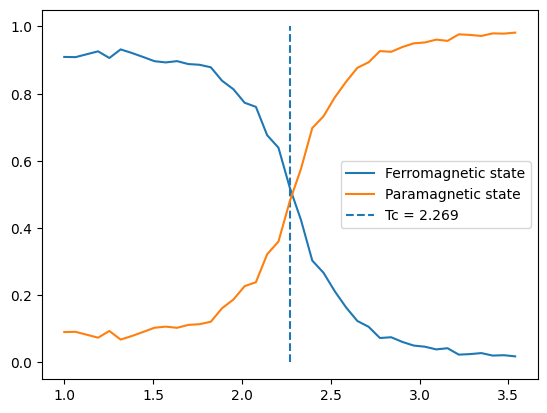

In [15]:
plot(T_test[1,:],class_1,label="Ferromagnetic state")
plot(T_test[1,:],class_2,label="Paramagnetic state")
plt.vlines([2.269],ymin=0,ymax=1,linestyle="dashed",label = "Tc = 2.269")
plt.legend()
plt.show()

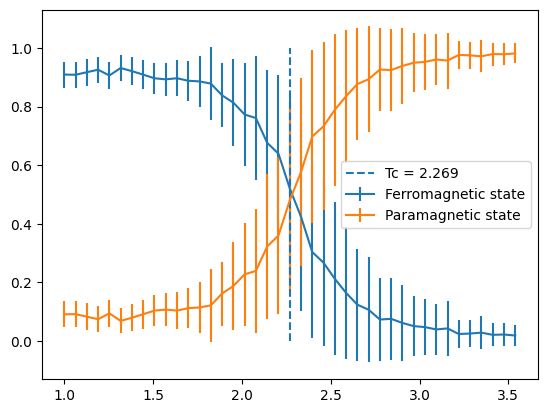

In [16]:
# With errorbars
errorbar(T_test[1,:],class_1,yerr=yerr_1,label="Ferromagnetic state")
errorbar(T_test[1,:],class_2,yerr=yerr_2,label="Paramagnetic state")
plt.vlines([2.269],ymin=0,ymax=1,linestyle="dashed",label = "Tc = 2.269")
plt.legend()
plt.show()

### Triangular lattice results
Using the same model trained from the square lattice data  
$T_c \approx 3.64$

In [17]:
# Data from https://github.com/carrasqu/data_nature_phy_paper
tri_T_test = [2.0000000000000000 2.0820478453253499 2.1640956906506998 2.2461435359760498 2.3281913813013997 2.4102392266267496 2.4922870719520995 2.5743349172774495 2.6563827626027994 2.7384306079281493 2.8204784532534992 2.9025262985788491 2.9845741439041991 3.0666219892295490 3.1486698345548989 3.2307176798802488 3.3127655252055987 3.3948133705309487 3.4768612158562986 3.5589090611816485 3.6409569065069984 3.7230047518323484 3.8050525971576983 3.8871004424830482 3.9691482878083981 4.0511961331337485 4.1332439784590989 4.2152918237844492 4.2973396691097996 4.3793875144351500 4.4614353597605003 4.5434832050858507 4.6255310504112011 4.7075788957365514 4.7896267410619018 4.8716745863872521 4.9537224317126025 5.0357702770379529 5.1178181223633032 5.1998659676886536 5.2819138130140004]
tri_test_x = load_x(L,"test",n,true)
tri_test_y = load_y(L,"test",n,true);

In [18]:
tri_yerr_1 = []
tri_yerr_2 = []
tri_class_1 = []
tri_class_2 = []
i = 1
count = n_T_test
for T in tri_T_test
    pred = neural_network(reshape(tri_test_x[:,i:i+count-1],L*L,count))
    push!(tri_class_1,mean(pred[1,:]))
    push!(tri_class_2,mean(pred[2,:]))
    push!(tri_yerr_1,std(pred[1,:]))
    push!(tri_yerr_2,std(pred[2,:]))
    i += count
end

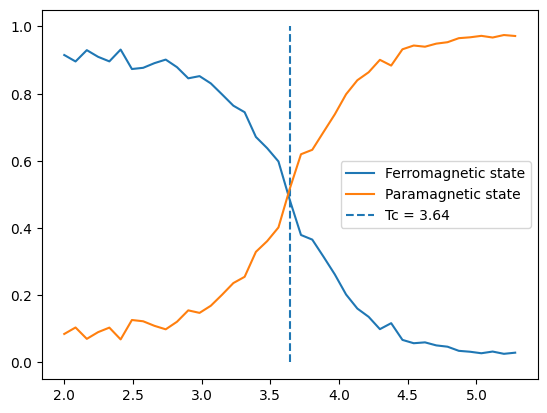

In [19]:
plot(tri_T_test[1,:],tri_class_1,label="Ferromagnetic state")
plot(tri_T_test[1,:],tri_class_2,label="Paramagnetic state")
plt.vlines([3.64],ymin=0,ymax=1,linestyle="dashed",label = "Tc = 3.64")
plt.legend()
plt.show()

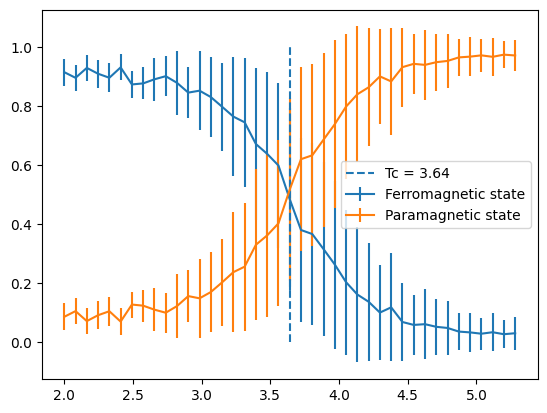

In [20]:
# With errorbars
errorbar(tri_T_test[1,:],tri_class_1,yerr=tri_yerr_1,label="Ferromagnetic state")
errorbar(tri_T_test[1,:],tri_class_2,yerr=tri_yerr_2,label="Paramagnetic state")
plt.vlines([3.64],ymin=0,ymax=1,linestyle="dashed",label = "Tc = 3.64")
plt.legend()
plt.show()